<a href="https://colab.research.google.com/github/Prothoma2001/Real-Time-Bangla-Sign-Language-Recognition-Thesis-/blob/main/Real_Time_Sign_Language_Recognition_(Main_Code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#hybrid Transformer-based model

In [5]:
!pip install -q git+https://github.com/tensorflow/docs

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import imageio
import cv2
from imutils import paths
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import seaborn as sns
from sklearn.metrics import confusion_matrix

from collections import namedtuple
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional
from torch import Tensor
from torch.hub import load_state_dict_from_url

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset_path = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Training')
label_types = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Training')

print (label_types)  

['92', '91', '96', '97', '99', '94', '98', '95', '93', '90', '89', '84', '88', '85', '82', '83', '81', '86', '87', '9', '73', '77', '78', '80', '72', '74', '75', '8', '76', '79', '7', '69', '64', '63', '68', '65', '70', '67', '66', '71', '56', '61', '58', '6', '55', '62', '54', '59', '57', '60', '46', '45', '52', '48', '50', '47', '5', '49', '51', '53', '41', '36', '42', '39', '38', '40', '43', '37', '44', '4', '33', '34', '3', '31', '29', '30', '32', '35', '28', '27', '21', '20', '19', '2', '23', '18', '24', '22', '26', '25', '14', '12', '15', '16', '11', '10', '13', '1', '0', '17']


In [9]:
#preparing training data 

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Training' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/OPS22 - Main Dataset/Training' + '/' +item) + '/' + room))
    
# Build a dataframe        
train_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(train_df.head())
print(train_df.tail())

df = train_df.loc[:,['video_name','tag']]
df
df.to_csv('train.csv')

  tag                                         video_name
0  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
2  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
3  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
4  92  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
     tag                                         video_name
1482  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1483  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1484  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1485  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...
1486  17  /content/drive/MyDrive/OPS22 - Main Dataset/Tr...


In [10]:
#Preparing Test Data

dataset_path = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Testing')
print(dataset_path)

room_types = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Testing')
print("Types of activities found: ", len(dataset_path))

rooms = []

for item in dataset_path:
 # Get all the file names
 all_rooms = os.listdir('/content/drive/MyDrive/OPS22 - Main Dataset/Testing' + '/' +item)

 # Add them to the list
 for room in all_rooms:
    rooms.append((item, str('/content/drive/MyDrive/OPS22 - Main Dataset/Testing' + '/' +item) + '/' + room))
    
# Build a dataframe        
test_df = pd.DataFrame(data=rooms, columns=['tag', 'video_name'])
print(test_df.head())
print(test_df.tail())

df = test_df.loc[:,['video_name','tag']]
df
df.to_csv('test.csv')

['91', '96', '94', '92', '93', '90', '95', '98', '97', '99', '86', '81', '82', '9', '89', '84', '85', '87', '83', '88', '73', '76', '79', '72', '77', '74', '78', '8', '75', '80', '68', '7', '69', '63', '66', '64', '67', '71', '70', '65', '59', '55', '61', '54', '62', '57', '58', '6', '60', '56', '47', '45', '49', '51', '48', '53', '5', '50', '46', '52', '38', '42', '37', '44', '43', '39', '4', '36', '40', '41', '32', '35', '29', '34', '33', '27', '31', '3', '30', '28', '18', '20', '25', '19', '2', '23', '26', '24', '21', '22', '14', '12', '16', '1', '17', '10', '13', '15', '0', '11']
Types of activities found:  100
  tag                                         video_name
0  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
1  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
2  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
3  91  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
4  96  /content/drive/MyDrive/OPS22 - Main Dataset/Te...
    tag                            

In [11]:
MAX_SEQ_LENGTH = 300
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 10

In [12]:
#Data preparation

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 1487
Total videos for testing: 439


,Unnamed: 0,video_name,tag
495,495,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,68
122,122,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,93
627,627,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,6
870,870,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,53
401,401,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,8
1123,1123,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,32
594,594,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,56
334,334,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,80
180,180,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,88
1409,1409,/content/drive/MyDrive/OPS22 - Main Dataset/Tr...,10


In [13]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)






#Change
def build_feature_extractor():
    __all__ = ['Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs']


    model_urls = {
    # Inception v3 ported from TensorFlow
       'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
    }

    InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
    InceptionOutputs.__annotations__ = {'logits': torch.Tensor, 'aux_logits': Optional[torch.Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _InceptionOutputs set here for backwards compat
    _InceptionOutputs = InceptionOutputs


    def inception_v3(pretrained=False, progress=True, **kwargs):
      r"""Inception v3 model architecture from
      `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
      .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.
      Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        aux_logits (bool): If True, add an auxiliary branch that can improve training.
            Default: *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
      """
      if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' in kwargs:
            original_aux_logits = kwargs['aux_logits']
            kwargs['aux_logits'] = True
        else:
            original_aux_logits = True
        kwargs['init_weights'] = False  # we are loading weights from a pretrained model
        model = Inception3(**kwargs)
        state_dict = load_state_dict_from_url(model_urls['inception_v3_google'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        if not original_aux_logits:
            model.aux_logits = False
            del model.AuxLogits
        return model

      return Inception3(**kwargs)


    class Inception3(nn.Module):

      def __init__(self, num_classes=1000, aux_logits=True, transform_input=False,
                 inception_blocks=None, init_weights=None):
        super(Inception3, self).__init__()
        if inception_blocks is None:
            inception_blocks = [
                BasicConv2d, InceptionA, InceptionB, InceptionC,
                InceptionD, InceptionE, InceptionAux
            ]
        if init_weights is None:
            warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
                          'torchvision. If you wish to keep the old behavior (which leads to long initialization times'
                          ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
            init_weights = True
        assert len(inception_blocks) == 7
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(2048, num_classes)
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    import scipy.stats as stats
                    stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                    X = stats.truncnorm(-2, 2, scale=stddev)
                    values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                    values = values.view(m.weight.size())
                    with torch.no_grad():
                        m.weight.copy_(values)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

      def _transform_input(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

      def _forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux_defined = self.training and self.aux_logits
        if aux_defined:
            aux = self.AuxLogits(x)
        else:
            aux = None
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

      @torch.jit.unused
      def eager_outputs(self, x, aux):
        # type: (Tensor, Optional[Tensor]) -> InceptionOutputs
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x

      def forward(self, x):
        x = self._transform_input(x)
        x, aux = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted Inception3 always returns Inception3 Tuple")
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)


    class InceptionA(nn.Module):

      def __init__(self, in_channels, pool_features, conv_block=None):
        super(InceptionA, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

      def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

      def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


    class InceptionB(nn.Module):

      def __init__(self, in_channels, conv_block=None):
        super(InceptionB, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

      def _forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

      def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


    class InceptionC(nn.Module):

      def __init__(self, in_channels, channels_7x7, conv_block=None):
        super(InceptionC, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

      def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

      def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


    class InceptionD(nn.Module):

      def __init__(self, in_channels, conv_block=None):
        super(InceptionD, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

      def _forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

      def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


    class InceptionE(nn.Module):

      def __init__(self, in_channels, conv_block=None):
        super(InceptionE, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

      def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

      def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


    class InceptionAux(nn.Module):

      def __init__(self, in_channels, num_classes, conv_block=None):
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

      def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


    class BasicConv2d(nn.Module):

      def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

      def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)










feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.IntegerLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [14]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [15]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [16]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [17]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

Epoch 1/10
16/16 [==============================] - ETA: 0s - loss: 2.5624 - accuracy: 0.5655
Epoch 1: val_loss improved from inf to 6.96322, saving model to /tmp/video_classifier
16/16 [==============================] - 9s 498ms/step - loss: 2.5624 - accuracy: 0.5655 - val_loss: 6.9632 - val_accuracy: 0.0000e+00
Epoch 2/10
16/16 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.9127
Epoch 2: val_loss improved from 6.96322 to 2.64265, saving model to /tmp/video_classifier
16/16 [==============================] - 9s 602ms/step - loss: 0.2712 - accuracy: 0.9127 - val_loss: 2.6426 - val_accuracy: 0.2333
Epoch 3/10
16/16 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9722
Epoch 3: val_loss improved from 2.64265 to 0.83634, saving model to /tmp/video_classifier
16/16 [==============================] - 8s 482ms/step - loss: 0.0843 - accuracy: 0.9722 - val_loss: 0.8363 - val_accuracy: 0.7222
Epoch 4/10
16/16 [==============================] - ETA

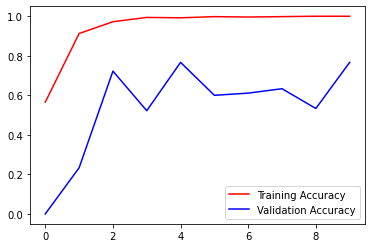

In [25]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


    plt.plot(history.history["accuracy"],'r', label="Training Accuracy")
    plt.plot(history.history["val_accuracy"],'b', label="Validation Accuracy")
    plt.legend()

    return history,model
    
trained_model = run_experiment() 

In [ ]:
#sequence_model.save('model.h5')